# Causal and statistical dependence
---

## Causal Dependence
Probabilistic programs encode knowledge about the world in the form of causal models, and it is useful to understand how their function relates to their structure by thinking about some of the intuitive properties of causal relations. Causal relations are local, modular, and directed. They are *modular* in the sense that any two arbitrary events in the world are most likely causally unrelated, or independent. If they are related, or dependent, the relation is only very weak and liable to be ignored in our mental models. Causal structure is *local* in the sense that many events that are related are not related directly: They are connected only through causal chains of several steps, a series of intermediate and more local dependencies. And the basic dependencies are *directed*: when we say that A causes B, it means something different than saying that B causes A. The *causal influence* flows only one way along a causal relation—we expect that manipulating the cause will change the effect, but not vice versa—but *information* can flow both ways—learning about either event will give us information about the other.

Let’s examine this notion of “causal dependence” a little more carefully. What does it mean to believe that A depends causally on B? Viewing cognition through the lens of probabilistic programs, the most basic notions of causal dependence are in terms of the structure of the program and the flow of evaluation (or “control”) in its execution. We say that expression A causally depends on expression B if it is necessary to evaluate B in order to evaluate A. (More precisely, expression A depends on expression B if it is ever necessary to evaluate B in order to evaluate A.) For instance, in this program `A` depends on `B` but not on `C` (the final expression depends on both `A` and `C`):

In [4]:
using Gen
include("auxilery.jl")

c = bernoulli(0.5)
b = bernoulli(0.5)
a = b ? bernoulli(0.1) : bernoulli(0.4)

a || c

false

Note that causal dependence order is weaker than a notion of ordering in time—one expression might happen to be evaluated before another in time (for instance `C` before `A`), but without the second expression requiring the first. (This notion of causal dependence is related to the notion of flow dependence in the programming language literature.)

For example, consider a simpler variant of our medical diagnosis scenario:

In [5]:
function importence_resamplin_inference(model, var,value, amount_of_computation, args=())
    # Create a choice map that maps model addresses - var 
    # to observed value - value. We leave other variables
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    observations[var] = value
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, args, observations, amount_of_computation);
    return trace
end

importence_resamplin_inference (generic function with 2 methods)

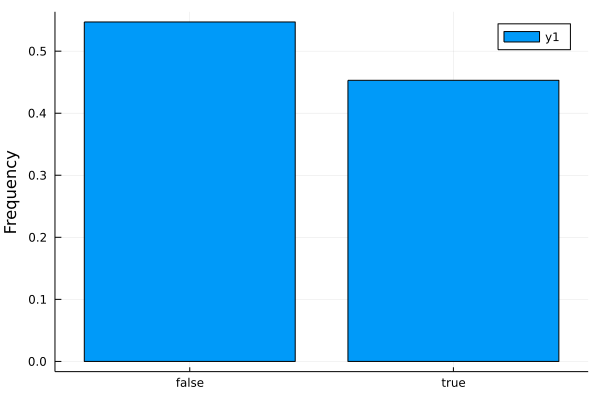

In [6]:
@gen function marg()
    smokes = @trace(bernoulli(0.2), :smokes)
    lungDisease = (smokes && @trace(bernoulli(0.1), :lungDisease1)) || @trace(bernoulli(0.001), :lungDisease2)
    cold = @trace(bernoulli(0.02), :cold)
    cough = (cold && @trace(bernoulli(0.5), :cough1)) || (lungDisease && @trace(bernoulli(0.5), :cough2)) || @trace(bernoulli(0.001), :cough3)
    fever = (cold && @trace(bernoulli(0.3), :fever1)) || @trace(bernoulli(0.01), :fever2)
    chestPain = (lungDisease && @trace(bernoulli(0.2), :chestPain1)) || @trace(bernoulli(0.01), :chestPain2)
    shortnessOfBreath = (lungDisease && @trace(bernoulli(0.2), :shortnessOfBreath1)) || @trace(bernoulli(0.01), :shortnessOfBreath2)

    if cough
        @trace(bernoulli(0.999), :"cough")
    else
        @trace(bernoulli(0.001), :"cough")
    end
    
    return Dict(["cold" => cold, "lungDisease" => lungDisease])
end

cold_ys = []
lungDisease_ys = []
for _ in 1:1000
    trace = importence_resamplin_inference(marg, "cough" ,true, 1000)
    push!(cold_ys, get_retval(trace)["cold"])
    push!(lungDisease_ys, get_retval(trace)["lungDisease"])
end

viz(cold_ys)

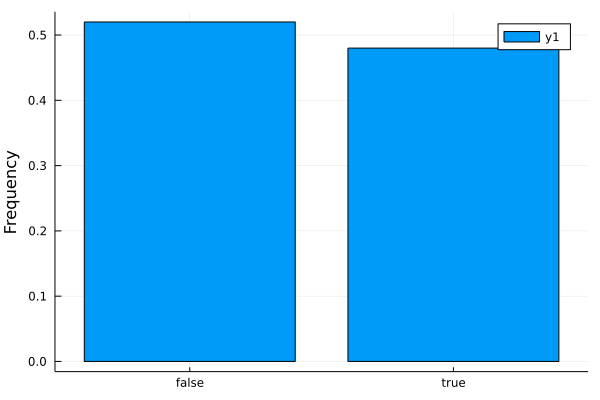

In [7]:
viz(lungDisease_ys)

Here, cough depends causally on both `lungDisease` and `cold`, while `fever` depends causally on `cold` but not `lungDisease`. We can see that `cough` depends causally on `smokes` but only indirectly: although `cough` does not call `smokes` directly, in order to evaluate whether a patient coughs, we first have to evaluate the expression `lungDisease` that must itself evaluate `smokes`.

We haven’t made the notion of “direct” causal dependence precise: do we want to say that `cough` depends directly on `cold`, or only directly on the expression `(cold && bernoulli(0.5)) || ...`? This can be resolved in several ways that all result in similar intuitions. For instance, we could first re-write the program into a form where each intermediate expression is named (called A-normal form) and then say direct dependence is when one expression immediately includes the name of another.

There are several special situations that are worth mentioning. In some cases, whether expression A requires expression B will depend on the value of some third expression C. For example, here is a particular way of writing a noisy-AND relationship:

In [8]:
C = bernoulli(0.5)
B = bernoulli(0.5)
A = (C ? (B ? bernoulli(0.85) : false) : false)
A

false

A always requires C, but only evaluates B if C returns true. Under the above definition of causal dependence A depends on B (as well as C). However, one could imagine a more fine-grained notion of causal dependence that would be useful here: we could say that A depends causally on B only in certain *contexts* (just those where C happens to return true and thus A calls B).

Another nuance is that an expression that occurs inside a function body may get evaluated several times in a program execution. In such cases it is useful to speak of causal dependence between specific evaluations of two expressions. (However, note that if a specific evaluation of A depends on a specific evaluation of B, then any other specific evaluation of A will depend on *some* specific evaluation of B. Why?)

## Detecting Dependence Through Intervention
The causal dependence structure is not always immediately clear from examining a program, particularly where there are complex functions calls. Another way to detect (or according to some philosophers, such as Jim Woodward, to *define*) causal dependence is more operational, in terms of “difference making”: If we manipulate A, does B tend to change? By *manipulate* here we don’t mean an assumption in the sense of condition. Instead we mean actually edit, or *intervene on*, the program in order to make an expression have a particular value independent of its (former) causes. If setting A to different values in this way changes the distribution of values of B, then B causally depends on A.

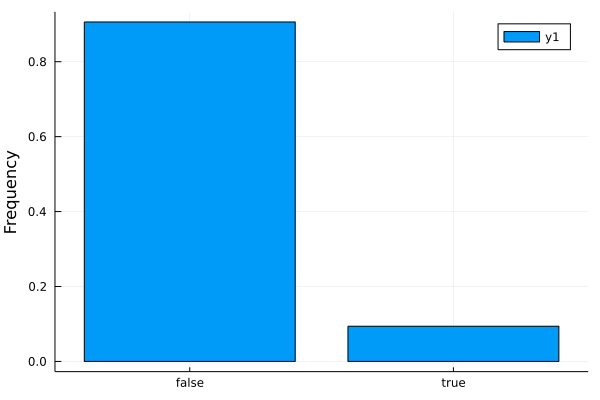

In [9]:
@gen function BdoA(Aval)
  C = @trace(bernoulli(0.5), :C)
  A = Aval  # we directly set A to the target value
  B = (A ? @trace(bernoulli(0.1), :B) : @trace(bernoulli(0.4), :B))
  return B
end

true_ys = [BdoA(true) for _ in 1:1000]  
viz(true_ys)

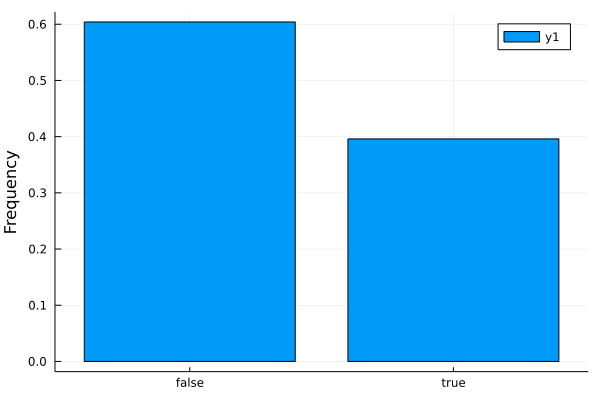

In [10]:
false_ys = [BdoA(false) for _ in 1:1000]  
viz(false_ys)

This method is known in the causal Bayesian network literature as the “do operator” or graph surgery (Pearl, 1988). It is also the basis for interesting theories of counterfactual reasoning by Pearl and colleagues (Halpern, Hitchcock and others).

For example, this code represents whether a patient is likely to have a cold or a cough *a priori*, without conditions or observations:

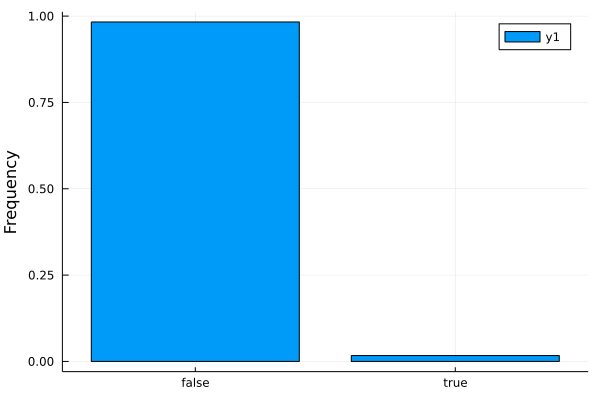

In [11]:
@gen function medicalDist()
    smokes = @trace(bernoulli(0.2), :smokes)
    lungDisease = (smokes && @trace(bernoulli(0.1), :lungDisease)) || @trace(bernoulli(0.001), :lungDisease)
    cold = @trace(bernoulli(0.02), :cold)

    cough = (cold && @trace(bernoulli(0.5), :cough)) || (lungDisease && @trace(bernoulli(0.5), :cough)) || @trace(bernoulli(0.001), :cough)
    fever = (cold && @trace(bernoulli(0.3), :fever)) || @trace(bernoulli(0.01), :fever)
    chestPain = (lungDisease && @trace(bernoulli(0.2), :chestPain)) || @trace(bernoulli(0.01), :chestPain)
    shortnessOfBreath = (lungDisease && @trace(bernoulli(0.2), :shortnessOfBreath)) || @trace(bernoulli(0.01), :shortnessOfBreath)

    return Dict(["cold" => cold, "cough" => cough])
end

cold_ys = []
cough_ys = []
for _ in 1:1000
    res = medicalDist()
    push!(cold_ys, res["cold"])
    push!(cough_ys, res["cough"])
end

viz(cold_ys)

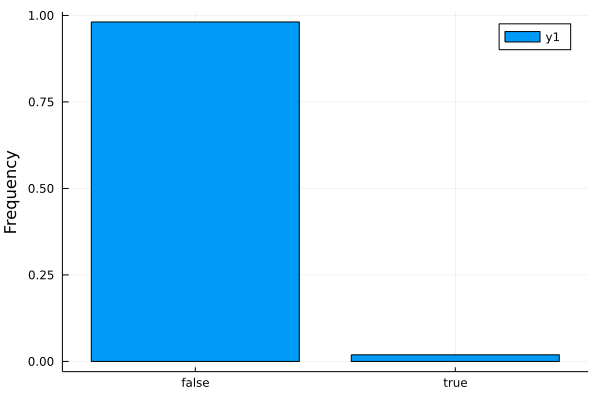

In [12]:
viz(cough_ys)

Imagine we now *give* our hypothetical patient a cold—for example, by exposing him to a strong cocktail of cold viruses. We should not model this as an observation (e.g. by conditioning on having a cold), because we have taken direct action to change the normal causal structure. Instead we implement intervention by directly editing the program: try to first do `cold = true`, then do `cold = false`:

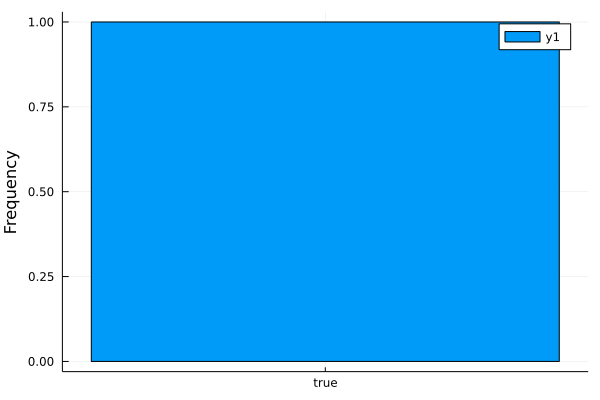

In [13]:
@gen function medicalDistColdTrue()
    smokes = @trace(bernoulli(0.2), :smokes)
    lungDisease = (smokes && @trace(bernoulli(0.1), :lungDisease)) || @trace(bernoulli(0.001), :lungDisease)
    cold = true      # we intervene to make cold true

    cough = (cold && @trace(bernoulli(0.5), :cough)) || (lungDisease && @trace(bernoulli(0.5), :cough)) || @trace(bernoulli(0.001), :cough)
    fever = (cold && @trace(bernoulli(0.3), :fever)) || @trace(bernoulli(0.01), :fever)
    chestPain = (lungDisease && @trace(bernoulli(0.2), :chestPain)) || @trace(bernoulli(0.01), :chestPain)
    shortnessOfBreath = (lungDisease && @trace(bernoulli(0.2), :shortnessOfBreath)) || @trace(bernoulli(0.01), :shortnessOfBreath)

    return Dict(["cold" => cold, "cough" => cough])
end

cold_ys = []
cough_ys = []
for _ in 1:1000
    res = medicalDistColdTrue()
    push!(cold_ys, res["cold"])
    push!(cough_ys, res["cough"])
end

viz(cold_ys)

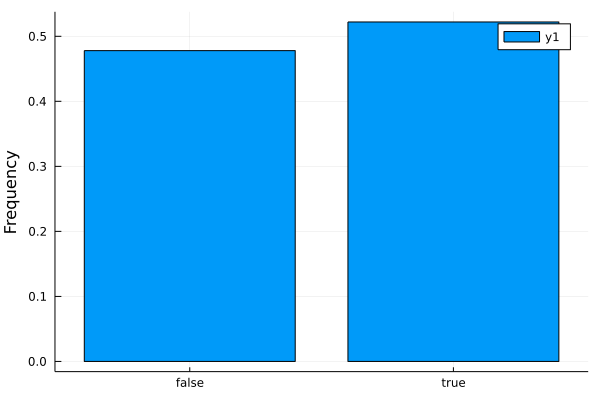

In [14]:
viz(cough_ys)

You should see that the distribution on `cough` changes: coughing becomes more likely if we know that a patient has been given a cold by external intervention. But the reverse is not true: Try forcing the patient to have a cough (e.g., with some unusual drug or by exposure to some cough-inducing dust) by writing `cough = true`: the distribution on `cold` is unaffected. We have captured a familiar fact: treating the symptoms of a disease directly doesn’t cure the disease (taking cough medicine doesn’t make your cold go away), but treating the disease *does* relieve the symptoms.

Verify in the program above that the method of manipulation works also to identify causal relations that are only indirect: for example, force a patient to smoke and show that it increases their probability of coughing, but not vice versa.

If we are given a program representing a causal model, and the model is simple enough, it is straightforward to read off causal dependencies from the program code itself. However, the notion of causation as difference-making may be easier to compute in much larger, more complex models—and it does not require an analysis of the program code. As long as we can modify (or imagine modifying) the definitions in the program and can run the resulting model, we can compute whether two events or functions are causally related by the difference-making criterion.

## Statistical Dependence
One often hears the warning, “correlation does not imply causation”. By “correlation” we mean a different kind of dependence between events or functions—*statistical dependence*. We say that A and B are statistically dependent, if learning information about A tells us something about B, and vice versa. In the language of Gen: using `observations` to make an assumption about A changes the value expected for B. Statistical dependence is a symmetric relation between events referring to how information flows between them when we observe or reason about them. (If conditioning on A changes B, then conditioning on B also changes A. Why?) The fact that we need to be warned against confusing statistical and causal dependence suggests they are related, and indeed, they are. In general, if A causes B, then A and B will be statistically dependent. (One might even say the two notions are “causally related”, in the sense that causal dependencies give rise to statistical dependencies.)

Diagnosing statistical dependence using `observations` is similar to diagnosing causal dependence through intervention. We condition on various values of the possible statistical dependent, here `A`, and see whether it changes the distribution on the target, here `B`:

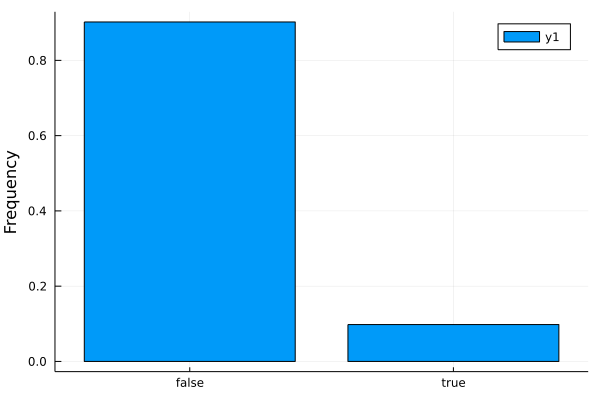

In [34]:
@gen function BcondA()
    C = @trace(bernoulli(0.5), :C)
    A = @trace(bernoulli(0.5), :A)
    B = A ? @trace(bernoulli(0.1), :B) : @trace(bernoulli(0.4), :B)
    return B
end

ys_true = []
ys_false = []

function BcondAInfer(model,Avalue,amountOfSamples)
    observations = Gen.choicemap()
    observations[:A] = Avalue
    
    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
end

for _ in 1:1000
    trace = BcondAInfer(BcondA  ,true, 1000)
    push!(ys_true, trace[:B])
    trace = BcondAInfer(BcondA ,false, 1000)
    push!(ys_false, trace[:B])
end

viz(ys_true)

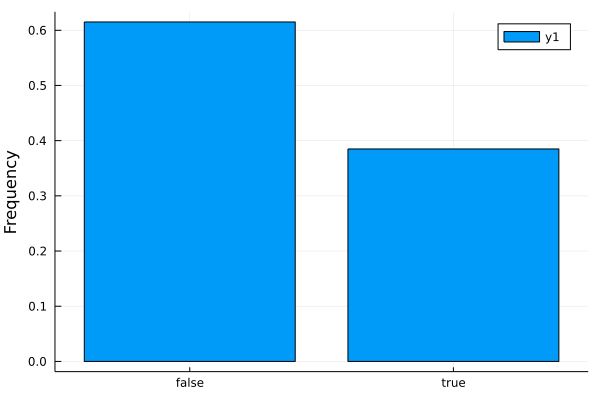

In [35]:
viz(ys_false)

Because the two distributions on `B` (when we have different information about `A`) are different, we can conclude that `B` statistically depends on `A`. Do the same procedure for testing if `A` statistically depends on `B`. How is this similar (and different) from the causal dependence between these two? As an exercise, make a version of the above medical example to test the statistical dependence between `cough` and `cold`. Verify that statistical dependence holds symmetrically for events that are connected by an indirect causal chain, such as `smokes` and `coughs`.

Correlation is not just a symmetrized version of causality. Two events may be statistically dependent even if there is no causal chain running between them, as long as they have a common cause (direct or indirect). That is, two expressions in a Gen program can be statistically dependent if one calls the other, directly or indirectly, or if they both at some point in their evaluation histories refer to some other expression (a “common cause”). Here is an example of statistical dependence generated by a common cause:

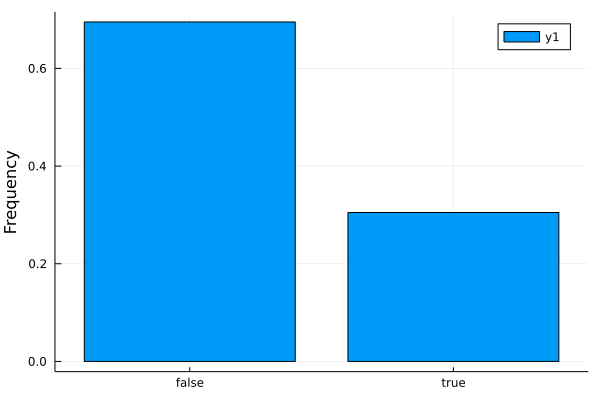

In [38]:
@gen function BcondA2()
    C = @trace(bernoulli(0.5), :C)
    A = C ? @trace(bernoulli(0.5), :A) : @trace(bernoulli(0.9), :A)
    B = C ? @trace(bernoulli(0.1), :B) : @trace(bernoulli(0.4), :B)
    return B
end

ys_true = []
ys_false = []

function BcondAInfer(model,Avalue,amountOfSamples)
    observations = Gen.choicemap()
    observations[:A] = Avalue
    
    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
end

for _ in 1:1000
    trace = BcondAInfer(BcondA2  ,true, 1000)
    push!(ys_true, trace[:B])
    trace = BcondAInfer(BcondA2 ,false, 1000)
    push!(ys_false, trace[:B])
end

viz(ys_true)

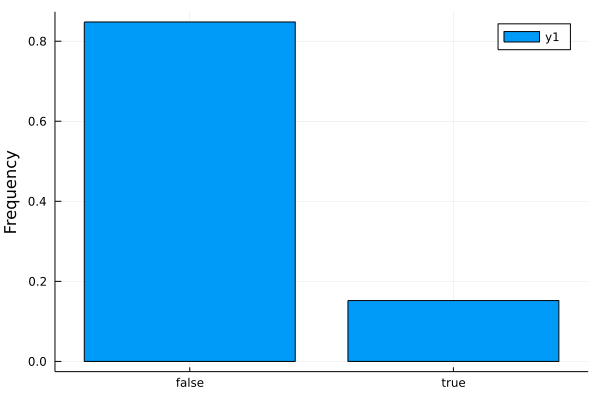

In [39]:
viz(ys_false)

Situations like this are extremely common. In the medical example above, `cough` and `fever` are not causally dependent but they are statistically dependent, because they both depend on `cold`; likewise for `chestPain` and `shortnessOfBreath` which both depend on `lungDisease`. Here we can read off these facts from the program definitions, but more generally all of these relations can be diagnosed by reasoning using inference functions.

Successful learning and reasoning with causal models typically depends on exploiting the close coupling between causation and correlation. Causal relations are typically unobservable, while correlations are observable from data. Noticing patterns of correlation is thus often the beginning of causal learning, or discovering what causes what. On the other hand, with a causal model already in place, reasoning about the statistical dependencies implied by the model allows us to predict many aspects of the world not directly observed from those aspects we do observe.

## Graphical Notations for Dependence
*Graphical models* are an extremely important idea in modern machine learning: a graphical diagram is used to represent the direct dependence structure between random choices in a probabilistic model. A special case are *Bayesian networks*, in which there is a node for each random variable (an expression in our terms) and a link between two nodes if there is a direct conditional dependence between them (a direct causal dependence in our terms). The sets of nodes and links define a *directed acyclic graph* (hence the term graphical model), a data structure over which many efficient algorithms can be defined. Each node has a *conditional probability table* (CPT), which represents the probability distribution of that node, given values of its parents. The joint probability distribution over random variables is given by the product of the conditional distributions for each variable in the graph.

The figure below defines a Bayesian network for the medical diagnosis example. The graph contains a node for each variable statement in our Gen program, with links to that node from each variable that appears in the assignment expression. There is a probability table (“CPT”) for each node, with a column for each value of the variable, and a row for each combination of values for its parents in the graph.

![](./images/Med-diag-bnet1.jpeg)

Simple generative models will have a corresponding graphical model that captures all of the dependencies (and *independencies*) of the model, without capturing the precise *form* of these functions. For example, while the graphical model shown above faithfully represents the probability distribution encoded by the Gen program, it captures the *noisy-OR* form of the causal dependencies only implicitly. As a result, the CPTs provide a less compact representation of the conditional probabilities than the Gen model. For instance, the CPT for `cough` specifies 4 parameters – one for each pair of values of `lungDisease` and `cold` (the second entry in each row is determined by the constraint that the conditional distribution of `cough` must sum to 1). In contrast, the variable statement for `cough` in Gen specifies only 3 parameters: the base rate of `cough`, and the strength with which `lungDisease` and `cold` cause `cough`. This difference becomes more pronounced for *noisy-OR* relations with many causes – the size of the CPT for a node will be exponential in the number of parents, while the number of terms in the noisy-OR expression in Gen for that node will be linear in the number of causal dependencies (why?). As we will see, this has important implications for the ability to learn the values of the parameters from data.

More complicated generative models, which can be expressed as probabilistic programs, often don’t have such a graphical model (or rather they have many approximations, none of which captures all independencies). Recursive models generally give rise to such ambiguous (or loopy) Bayes nets.

Next chapter: [5. Conditional dependence](https://github.com/daryanon/ProbMods.jl/blob/main/chapter5.ipynb)